## Load libraries

In [1]:
library(RPostgreSQL)
library(ggplot2)
library(dplyr)
require(tidyr)
library(igraph)

Loading required package: DBI


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr


Attaching package: ‘igraph’


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [2]:
here::i_am("read-from-database/Read-table-traits-sources.ipynb")


here() starts at /Users/z3529065/proyectos/fireveg/fireveg-analysis



## Connect to the database
We store connections parameters in our `secrets` folder

In [3]:
conn_params <- here::here("secrets/database.ini")
if (file.exists(conn_params)) {
  tmp <- readLines(conn_params)[-1]
  tmp <- strsplit(tmp,'=',fixed=2)
  dbinfo <- unlist(lapply(tmp,function(x) x[2]))
  names(dbinfo) <- unlist(lapply(tmp,function(x) x[1]))
  dbinfo <- data.frame(t(dbinfo),stringsAsFactors=F)
   rm(tmp)
} else {
  cat("No database information found")
}

Get a connection to the database

In [4]:
drv <- dbDriver("PostgreSQL") ## 
con <- dbConnect(drv, dbname = dbinfo$database,
                 host = dbinfo$host, port = dbinfo$port,
                 user = dbinfo$user) # this works better in combination with a .pgpass file

## Query the database

### Trait descriptions

In [5]:
qry <- "SELECT code, name, description, life_stage, life_history_process, priority
FROM litrev.trait_info
"

In [6]:
trait_info <- dbGetQuery(con, qry)

In [7]:
filter(trait_info, !is.na(priority)) %>% 
    select(code,name,life_stage,life_history_process) %>%
    arrange(code)


code,name,life_stage,life_history_process
<chr>,<chr>,<chr>,<chr>
disp1,Propagule dispersal mode,Seed,Dispersal
germ1,Seedbank Type,Seed,Germination
germ8,Seed dormancy type,Seed,Germination
grow1,Age to develop regenerative/resistance organs,Standing plant,Growth
rect2,Establishment pattern,Seedling,Recruitment
repr2,Post-fire flowering response,Standing plant,Reproduction
repr3,Age at first flower production (from seed),Standing plant,Reproduction
repr3a,Time to first postfire reproduction (from resprouts),Standing plant,Reproduction
repr4,Maturation age,Standing plant,Reproduction


### Combine trait records

We use here a template query to retrieve the common metadata of each record (not including values).

In [8]:
qry <- 
"SELECT family, genus, \"speciesID\" as spp, 
\"scientificName\" as species,
'%1$s' as traitcode,
trait.record_id as rid,
main_source,
unnest(original_sources) as primary_source
FROM species.caps  
LEFT JOIN litrev.%1$s trait
    ON \"speciesCode_Synonym\"=trait.species_code::text;
"

We now run the queries substituting the trait codes into the query template

In [9]:
traits_table <- tibble()
priority_traits <- c("surv1", "surv4", "surv5", "surv6", "surv7",
                    "disp1",
                    "germ1", "germ8",
                    "grow1",
                    "repr2", "repr3", "repr3a", "repr4",
                    "rect2"
                    )
for (traitcode in priority_traits) {
    traits_table <- traits_table %>% 
    bind_rows(dbGetQuery(con, sprintf(qry,traitcode)))
}

Check the total numbers of records 

In [10]:
traits_table %>% 
    summarise(
        total=n(), 
        records=n_distinct(rid), 
        main_sources=n_distinct(main_source), 
        sources=n_distinct(primary_source))

total,records,main_sources,sources
<int>,<int>,<int>,<int>
38378,31458,3,269


In [11]:
head(traits_table)

family,genus,spp,species,traitcode,rid,main_source,primary_source
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>
Malvaceae,Abutilon,6947,Abutilon otocarpum,surv1,11565,NSWFFRDv2.1,Cheal pers. comm.
Malvaceae,Abutilon,9198,Abutilon oxycarpum,surv1,11567,NSWFFRDv2.1,Benson McDougall 1997
Malvaceae,Abutilon,9198,Abutilon oxycarpum,surv1,11568,NSWFFRDv2.1,Hunter Vegetation Washpool National Park Western A
Fabaceae (Mimosoideae),Acacia,9438,Acacia acanthoclada,surv1,11570,NSWFFRDv2.1,Cheal Day Meredith 1979
Fabaceae (Mimosoideae),Acacia,2718,Acacia acinacea,surv1,11572,NSWFFRDv2.1,Wark White Robertson Marriott 1987
Fabaceae (Mimosoideae),Acacia,2718,Acacia acinacea,surv1,11573,NSWFFRDv2.1,Wark 1997


In [12]:
dbDisconnect(con)

[1] TRUE

## Visualise graph of references


In [13]:
links <- traits_table %>% 
    group_by(from=primary_source, to=traitcode, main_source ) %>% 
    summarise(spp=n_distinct(spp), .groups="drop")

In [14]:
nrow(links)

[1] 567

In [15]:
node1 <- traits_table %>% 
    group_by(id=primary_source, type="ref") %>% 
    summarise(spp=n_distinct(spp), .groups="drop")
node2 <- traits_table %>% 
    group_by(id=traitcode, type="trait", label=traitcode) %>% 
    summarise(spp=n_distinct(spp), .groups="drop")


In [16]:
nodes <- bind_rows(node1,node2)

In [17]:
nrow(node2)

[1] 14

In [18]:
links %>% slice_sample(n=10)

from,to,main_source,spp
<chr>,<chr>,<chr>,<int>
Ashton Chappill 1989,surv1,NSWFFRDv2.1,3
Falster Westoby 2005,surv1,austraits-3.0.2,19
Blombery Maloney 1992,surv1,NSWFFRDv2.1,8
Bradstock 1990,surv5,NSWFFRDv2.1,2
McCaw 1997,repr3,NSWFFRDv2.1,5
Bradstock 1990,repr3,NSWFFRDv2.1,1
RP Acrophyllum australe,germ1,NSWFFRDv2.1,1
Morgan Lunt 1999,surv5,NSWFFRDv2.1,1
Morgan 1999,repr3a,NSWFFRDv2.1,3


In [19]:
g <- graph_from_data_frame(links,nodes,directed=F)

In [20]:
colrC <- c(ref = "orange", trait = "skyblue")
shapeC <- c(ref = "circle", trait = "csquare")
V(g)$color<- colrC[V(g)$type]
V(g)$shape<- shapeC[V(g)$type]
#change vertex size and edge color:
E(g)$edge.color <- "gray80"
V(g)$size <- log1p(V(g)$spp)*ifelse(V(g)$type=="ref",1,1.45)
#V(g)$size[V(g)$class %in% "EFG"] <- 6

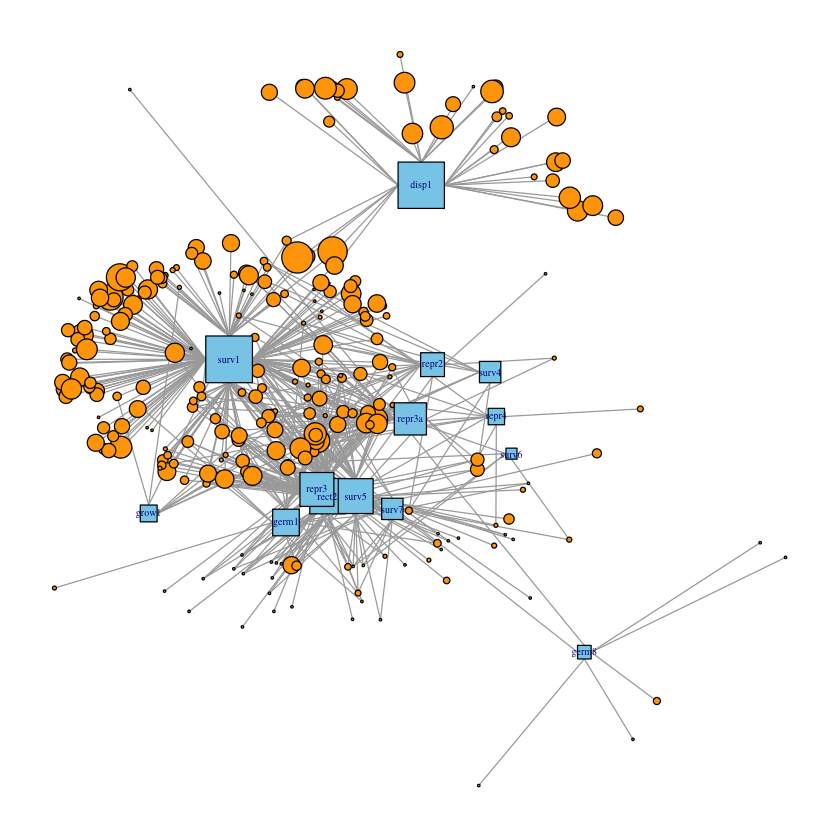

In [21]:
l <- layout_with_kk(g)
#l <- layout_nicely(g)
par(mar=c(0,0,0,0))
plot(g, layout=l,vertex.label.cex=.5)

In [22]:
E(g)

+ 567/567 edges from e1f837b (vertex names):
 [1] Adrian Pyrke Tas. unpub. --surv1 Angevin 2011             --disp1
 [3] Ashton Chappill 1989     --rect2 Ashton Chappill 1989     --repr3
 [5] Ashton Chappill 1989     --surv1 Ashton Chappill 1989     --surv5
 [7] Auld 1987                --repr3 Auld 1987                --surv1
 [9] Auld 1987                --surv5 Auld 1987                --surv6
[11] Auld 1987                --surv7 Auld 1991                --surv1
[13] Auld Keith Bradstock 2000--surv6 Auld Keith Bradstock 2000--surv7
[15] Auld Scott 1997          --germ1 Auld Scott 1997          --rect2
[17] Auld Scott 1997          --repr3 Auld Scott 1997          --surv1
[19] Auld Scott 1997          --surv5 Auld Scott 1997          --surv6
+ ... omitted several edges

## Save data

In [23]:
saveRDS(file=here::here('data','Summary-traits-sources.rds'),traits_table)

In [24]:
saveRDS(file=here::here('data','Trait-info.rds'),trait_info)